<h1>Imports<h1>

In [1]:
#setting rood directory into ../NeuralPowerDisaggregation
import os
os.chdir("..")
print(os.getcwd())

/work/lurny/files/Thesis


In [2]:
config = {
    'gdt': {
        'depth': 5,
                
        'learning_rate_index': 0.05,
        'learning_rate_values': 0.01,
        'learning_rate_leaf': 0.005,
        
        'dropout': 0,
        
        
        'initializer_values': 'GlorotUniform', 
        'initializer_index': 'GlorotUniform', 
        'initializer_leaf': 'GlorotUniform', 
        
        'optimizer': 'adam', 
        
        'batch_size': 512,
        'epochs': 1,
        
        'restarts': 10,
        'restart_type': 'loss', #'loss', 'metric'
        
        'early_stopping_epochs': 200,
        'early_stopping_type': 'loss', #'loss', 'metric'
        'early_stopping_epsilon': 0.0,
    },
    
    'preprocessing': {
        'balance_threshold': 0,#.25, #if minclass fraction less than threshold/num_classes | #0=no rebalance, 1=rebalance all
        'normalization_technique': 'mean', #'min-max'
    },

    'computation': {
        'random_seed': 42,
        'trials': 10, # fixed to 1 for HPO
        
        'use_best_hpo_result': True,
        'force_depth': False,
        
        'use_gpu': True,
        'gpu_numbers': '1',#'1',
        'n_jobs': 10, #vorher 20
        'verbosity': 0,
        
        
        'hpo': None,#'binary', #'binary', 'multi', 'regression'
        'search_iterations': 300,
        'cv_num': 3,     
        
        'metrics_class': ['f1', 'roc_auc', 'accuracy'],
        
        'metrics_reg': ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_absolute_error', 'neg_mean_squared_error'],
        
        'eval_metric_class': ['f1', 'roc_auc'], #f1 accuracy
        'eval_metric_reg': 'r2', #r2 mae        
        
        
    },
    
    'benchmarks': {
        'sklearn': True,
        #'GeneticTree': True,        
    }
}

In [3]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
#from pydl85 import DL85Classifier

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

if config['computation']['use_gpu']:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config['computation']['gpu_numbers'])
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-11.6"
    os.environ['TF_XLA_FLAGS'] = "--tf_xla_enable_xla_devices --tf_xla_auto_jit=2"    
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false' 
#os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit" 


import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["PYTHONWARNINGS"] = "ignore"
import logging

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities_GDT import *
from utilities.GDT_for_streams import *

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy
from pathlib import Path
import pickle
import dill

tf.random.set_seed(config['computation']['random_seed'])
np.random.seed(config['computation']['random_seed'])
random.seed(config['computation']['random_seed'])

from datetime import datetime
timestr = datetime.utcnow().strftime('%Y-%m-%d--%H-%M-%S%f')
print(timestr)
os.makedirs(os.path.dirname("./evaluation_results/latex_tables/" + timestr +"/"), exist_ok=True)

filepath = './evaluation_results/depth' + str(config['gdt']['depth']) + '/' + timestr + '/'
Path(filepath).mkdir(parents=True, exist_ok=True)    


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

2022-12-18--11-54-41227876


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  1


# Evaluation of agr_a dataset

In [8]:
dataset_dict, config_training, metrics = prepare_training(identifier = 'BIN:agr_a', config = config)

model_dict = {}

verbosity = 1

model_dict['GDT'] = GDT(number_of_variables = dataset_dict['number_of_variables'],
            number_of_classes = dataset_dict['number_of_classes'],

            objective = config_training['gdt']['objective'],

            depth = config_training['gdt']['depth'],

            learning_rate_index = config_training['gdt']['learning_rate_index'],
            learning_rate_values = config_training['gdt']['learning_rate_values'],
            learning_rate_leaf = config_training['gdt']['learning_rate_leaf'],

            optimizer = config_training['gdt']['optimizer'],

            loss = 'crossentropy',

            initializer_values = config_training['gdt']['initializer_values'],
            initializer_index = config_training['gdt']['initializer_index'],
            initializer_leaf = config_training['gdt']['initializer_leaf'],        

            random_seed = config_training['computation']['random_seed'],
            verbosity = verbosity)#5      


history = model_dict['GDT'].partial_fit(dataset_dict['X_train'],
          dataset_dict['y_train'],

          batch_size=config_training['gdt']['batch_size'], 
          epochs=config_training['gdt']['epochs'], 

          restarts = 0,#config_test['gdt']['restarts'], 
          #restart_type=config_test['gdt']['restart_type'], 

          #early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
          #early_stopping_type=config_test['gdt']['early_stopping_type'],

          valid_data=(dataset_dict['X_valid'], dataset_dict['y_valid']))


model_dict['sklearn'] = DecisionTreeClassifier(max_depth=config_training['gdt']['depth'], 
                                      random_state=config_training['computation']['random_seed'])

model_dict['sklearn'].fit(dataset_dict['X_train'], 
                          dataset_dict['y_train'])


# model_dict['GeneticTree'] = GeneticTree()
# model_dict['GeneticTree'] = model_dict['GeneticTree'].fit(dataset_dict['X_train'].values, 
#                                                           dataset_dict['y_train'].values)        


scores_dict = calculate_scores(model_dict = model_dict, 
                               dataset_dict = dataset_dict, 
                               scores_dict = prepare_score_dict(config=config_training), 
                               metrics = metrics)           

#model.set_params(**config_training['gdt'])   

NameError: name 'prepare_training' is not defined

In [7]:
history = model_dict['GDT'].partial_fit(dataset_dict['X_train'],
          dataset_dict['y_train'],

          batch_size=config_training['gdt']['batch_size'], 
          epochs=config_training['gdt']['epochs'], 

          restarts =0, #config_test['gdt']['restarts'], 
          #restart_type=config_test['gdt']['restart_type'], 

          #early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
          #early_stopping_type=config_test['gdt']['early_stopping_type'],

          valid_data=(dataset_dict['X_valid'], dataset_dict['y_valid']))


model_dict['sklearn'] = DecisionTreeClassifier(max_depth=config_training['gdt']['depth'], 
                                      random_state=config_training['computation']['random_seed'])

model_dict['sklearn'].fit(dataset_dict['X_train'], 
                          dataset_dict['y_train'])


# model_dict['GeneticTree'] = GeneticTree()
# model_dict['GeneticTree'] = model_dict['GeneticTree'].fit(dataset_dict['X_train'].values, 
#                                                           dataset_dict['y_train'].values)        


scores_dict = calculate_scores(model_dict = model_dict, 
                               dataset_dict = dataset_dict, 
                               scores_dict = prepare_score_dict(config=config_training), 
                               metrics = metrics)           

#model.set_params(**config_training['gdt'])   

NameError: name 'model_dict' is not defined

In [5]:
dataset_dict, config_training, metrics = prepare_training(identifier = 'BIN:agr_a', config = config)

               salary    commission  age  elevel  car  zipcode         hvalue  \
0       110499.735409      0.000000   54       3    6        4  135000.000000   
1       140893.779095      0.000000   44       4   12        7  135000.000000   
2       119159.651677      0.000000   49       2    0        3  135000.000000   
3        20000.000000  52593.636537   56       0   19        1  135000.000000   
4        93956.320488      0.000000   59       1    6        1  135000.000000   
...               ...           ...  ...     ...  ...      ...            ...   
999995   93207.738270      0.000000   27       1    1        8  121693.711227   
999996   36198.446917  47077.537587   36       0    8        7  135000.000000   
999997   42480.911813  53237.246918   62       3   11        1  135000.000000   
999998   74417.353314      0.000000   36       3    0        2  135000.000000   
999999  130706.084293      0.000000   22       1    5        8  133116.485072   

        hyears           lo

In [10]:
((X_train, y_train),
 (X_valid, y_valid),
 (X_test, y_test),
 normalizer_list) = preprocess_data(X_data, 
                                   y_data,
                                   nominal_features,
                                   ordinal_features,
                                   config,
                                   random_seed=random_seed,
                                   verbosity=verbosity)  
    

600000

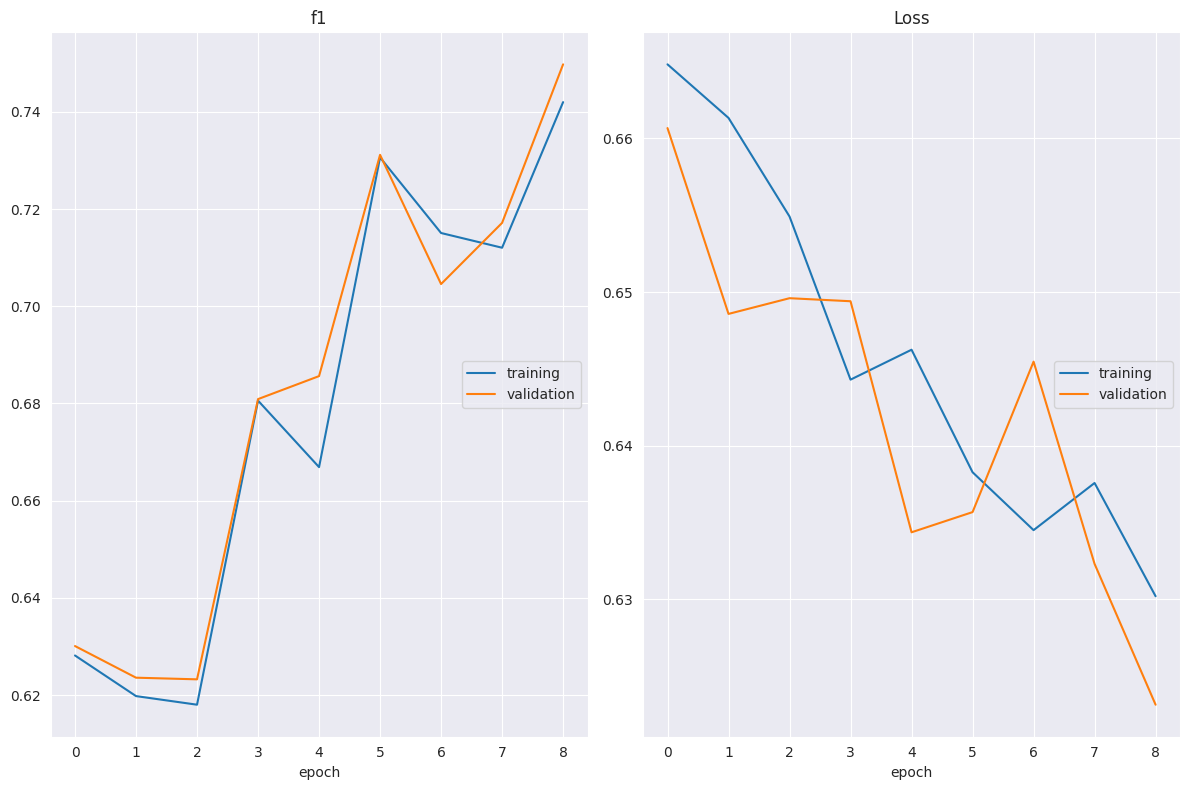

f1
	training         	 (min:    0.618, max:    0.742, cur:    0.742)
	validation       	 (min:    0.623, max:    0.750, cur:    0.750)
Loss
	training         	 (min:    0.630, max:    0.665, cur:    0.630)
	validation       	 (min:    0.623, max:    0.661, cur:    0.623)
Test f1 GDT (0) 0.7785766255541207
Test roc_auc GDT (0) 0.712489270386266
Test accuracy GDT (0) 0.8108108108108109
________________________________________________________________________________________________________
Original Data Shape (selected):  (1667, 5)
Original Data Shape (encoded):  (1667, 5)
Original Data Class Distribution:  560  (true) / 1107  (false)
(1001, 5) (1001,)
(333, 5) (333,)
(333, 5) (333,)
Min Ratio:  0.34565434565434566


restarts:   0%|          | 0/1 [00:00<?, ?it/s]

epochs:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from skmultiflow.trees import HoeffdingTreeClassifier
classifier = HoeffdingTreeClassifier()

config_training, metrics = prepare_training_for_streams(identifier = 'BIN:agr_a', config = config)
#load Dataset
X_data, y_data, nominal_features, ordinal_features = load_dataset_for_streams(identifier = 'BIN:agr_a')


X_data_stream = np.array_split(X_data, 30)
y_data_stream = np.array_split(y_data, 30)

model_dict = {}

benchmark_dict = {'y_pred':[],
                 'y_valid':[]}

verbosity = 1

model_dict['GDT'] = GDT(number_of_variables = 5,#dataset_dict['number_of_variables'],
            number_of_classes = 2,#dataset_dict['number_of_classes'],

            objective = config_training['gdt']['objective'],

            depth = config_training['gdt']['depth'],

            learning_rate_index = config_training['gdt']['learning_rate_index'],
            learning_rate_values = config_training['gdt']['learning_rate_values'],
            learning_rate_leaf = config_training['gdt']['learning_rate_leaf'],

            optimizer = config_training['gdt']['optimizer'],

            loss = 'crossentropy',

            initializer_values = config_training['gdt']['initializer_values'],
            initializer_index = config_training['gdt']['initializer_index'],
            initializer_leaf = config_training['gdt']['initializer_leaf'],        

            random_seed = config_training['computation']['random_seed'],
            verbosity = verbosity)  


for i in range(len(X_data_stream)):
    ((X_train, y_train),
     (X_valid, y_valid),
     (X_test, y_test),
     normalizer_list) = preprocess_data(X_data_stream[i], 
                                       y_data_stream[i],
                                       nominal_features,
                                       ordinal_features,
                                       config_training,
                                       random_seed= 42,#random_seed,
                                       verbosity=1)#verbosity)  
    dataset_dict = {
           'X_train': X_train,
           'y_train': y_train,
           'X_valid': X_valid,
           'y_valid': y_valid,
           'X_test': X_test,
           'y_test': y_test,
           'normalizer_list': normalizer_list
           }

    history = model_dict['GDT'].partial_fit(dataset_dict['X_train'],
              dataset_dict['y_train'],

              batch_size=config_training['gdt']['batch_size'], 
              epochs=config_training['gdt']['epochs'], 

              restarts = 0,#config_test['gdt']['restarts'], 
              #restart_type=config_test['gdt']['restart_type'], 

              #early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
              #early_stopping_type=config_test['gdt']['early_stopping_type'],

              valid_data=(dataset_dict['X_valid'],dataset_dict['y_valid']))
    
    
    #Hoeffding tree
    #for i in range(1, len(dataset_dict['X_train'])):
     #   benchmark_dict['y_pred'] = classifier.predict(dataset_dict['X_valid'].iloc[i,:].tolist())
      #  classifier.partial_fit(dataset_dict['X_train'].iloc[i,:].to_numpy(), float(dataset_dict['y_train'].iloc[i]))
        #print(dataset_dict['y_train'].iloc[i])
   # for row_X, row_y in zip(dataset_dict['X_train'].iterrows(), dataset_dict['y_train'].iterrows()):
    #    classifier.partial_fit(row_X, row_y)

    benchmark_dict['y_valid'].append(dataset_dict['y_valid'].values)
    
    temp_X_train =dataset_dict['X_train'].values
    temp_y_train =dataset_dict['y_train'].values
    temp_X_valid = dataset_dict['X_valid'].values
    
    for i in range(0, len(dataset_dict['X_valid'])):
        benchmark_dict['y_pred'].append(classifier.predict(np.array([temp_X_valid[i]], np.float64)))
    for i in range(0, len(dataset_dict['X_train'])):
        classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))

    


    #model_dict['sklearn'] = DecisionTreeClassifier(max_depth=config_training['gdt']['depth'], 
     #                                     random_state=config_training['computation']['random_seed'])

    #model_dict['sklearn'].fit(dataset_dict['X_train'], 
    #                          dataset_dict['y_train'])


    # model_dict['GeneticTree'] = GeneticTree()
    # model_dict['GeneticTree'] = model_dict['GeneticTree'].fit(dataset_dict['X_train'].values, 
    #                                                           dataset_dict['y_train'].values)        

    scores_dict = calculate_scores(model_dict = model_dict, 
                                   dataset_dict = dataset_dict, 
                                   scores_dict = prepare_score_dict(config=config_training), 
                                   metrics = metrics)            

#model.set_params(**config_training['gdt'])   

In [19]:
from skmultiflow.data import SEAGenerator
from skmultiflow.trees import HoeffdingTreeClassifier

stream = SEAGenerator(random_state=1)
classifier = HoeffdingTreeClassifier()
n_samples = 0
correct_cnt = 0
max_samples = 2000
# Prequential evaluation loop
while n_samples < max_samples and  stream.has_more_samples():
    X, y = stream.next_sample()
    # Predict class for new data 
    #print(X)
    #print(y[0])
    y_pred = classifier.predict(X) 
    if y[0] == y_pred[0]:
        correct_cnt += 1
    # Partially fit (train) model with new data 
    classifier.partial_fit(X, y)
    n_samples += 1
print('{} samples analyzed.'.format(n_samples)) 
print('Accuracy: {}'.format(correct_cnt / n_samples))

2000 samples analyzed.
Accuracy: 0.9395


In [38]:
benchmark_dict['y_pred'][0]

0